In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
from sklearn import svm
from sklearn import model_selection, metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'

train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)

In [4]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [5]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [6]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [7]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [8]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [9]:
train['source']='train'
test['source']='test'
train=train.append(test)
train.info()


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 592149 entries, 0 to 128857
Data columns (total 16 columns):
DateTime                  592149 non-null object
age_level                 568222 non-null float64
campaign_id               592149 non-null int64
city_development_index    432411 non-null float64
gender                    568222 non-null object
is_click                  463291 non-null float64
product                   592149 non-null object
product_category_1        592149 non-null int64
product_category_2        150124 non-null float64
session_id                592149 non-null int64
source                    592149 non-null object
user_depth                568222 non-null float64
user_group_id             568222 non-null float64
user_id                   592149 non-null int64
var_1                     592149 non-null int64
webpage_id                592149 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 76.8+ MB


In [10]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592149 entries, 0 to 592148
Data columns (total 18 columns):
DateTime                  592149 non-null object
age_level                 568222 non-null float64
campaign_id               592149 non-null int64
city_development_index    432411 non-null float64
gender                    568222 non-null object
is_click                  463291 non-null float64
product                   592149 non-null object
product_category_1        592149 non-null int64
product_category_2        150124 non-null float64
session_id                592149 non-null int64
source                    592149 non-null object
user_depth                568222 non-null float64
user_group_id             568222 non-null float64
user_id                   592149 non-null int64
var_1                     592149 non-null int64
webpage_id                592149 non-null int64
interest                  103101 non-null float64
view                      478310 non-null float64
dtype

In [12]:
t_click1=train[train.is_click==1]
train=train.append(t_click1)
train=train.append(t_click1)

In [13]:
train.isnull().sum()

DateTime                       0
age_level                  26475
campaign_id                    0
city_development_index    176702
gender                     26475
is_click                  128858
product                        0
product_category_1             0
product_category_2        492315
session_id                     0
source                         0
user_depth                 26475
user_group_id              26475
user_id                        0
var_1                          0
webpage_id                     0
interest                  540778
view                      125359
dtype: int64

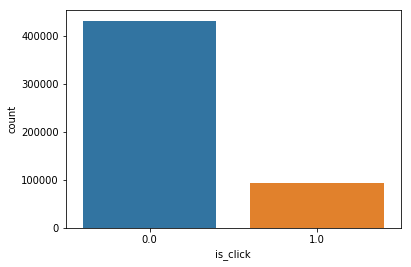

In [14]:
sb.countplot(train.is_click)

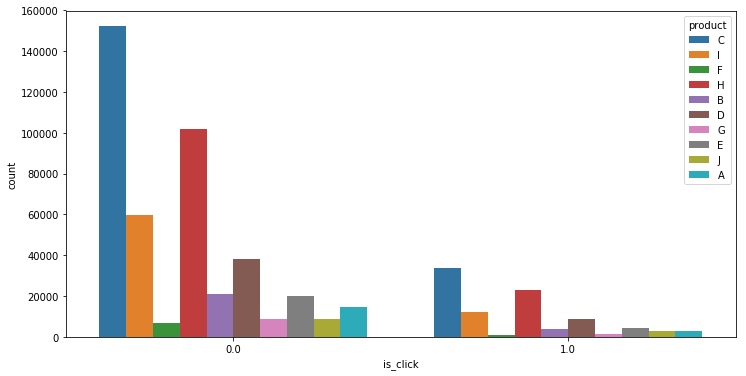

In [15]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='product', data=train)

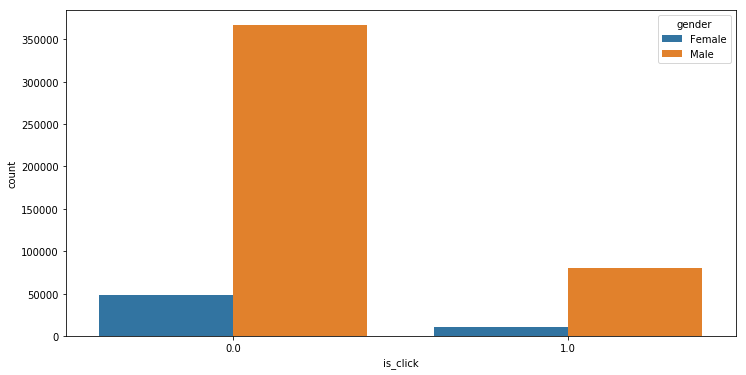

In [16]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='gender', data=train)

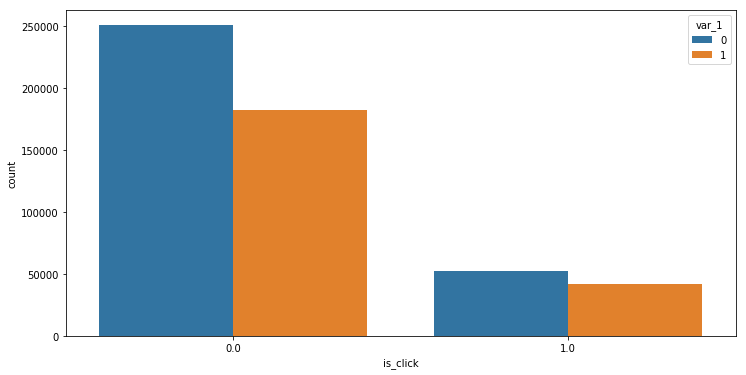

In [17]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_click', hue='var_1', data=train)

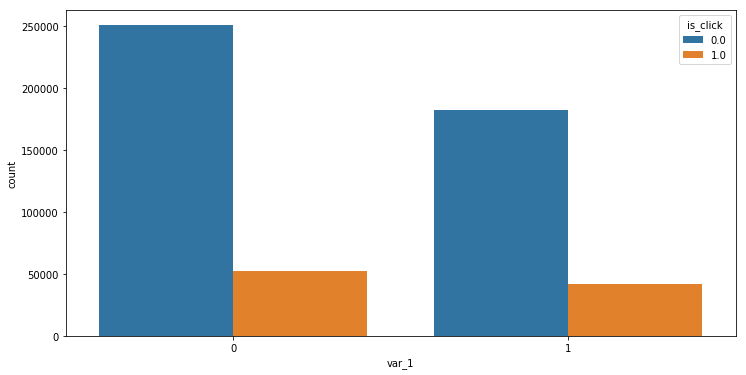

In [18]:
plt.figure(figsize=(12,6))
sb.countplot(x='var_1', hue='is_click', data=train)

In [19]:
train_label= train.is_click


In [20]:
train.gender=train.gender.fillna('Unknown')

In [21]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [22]:
train.age_level= train.age_level.fillna(method='pad')

In [23]:
train.user_depth= train.user_depth.fillna(method='pad')

In [24]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [25]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)

In [26]:
train=pd.get_dummies(train,columns=['gender','product'])

In [27]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,2017-07-02 00:00,4.0,359520,3.0,0.0,4,NaN,140690,train,3.0,...,0,0,1,0,0,0,0,0,0,0
1,2017-07-02 00:00,2.0,105960,3.0,0.0,5,NaN,333291,train,2.0,...,0,0,1,0,0,0,0,0,0,0
2,2017-07-02 00:00,2.0,359520,3.0,0.0,4,NaN,129781,train,2.0,...,0,0,1,0,0,0,0,0,0,0
3,2017-07-02 00:00,3.0,359520,2.0,0.0,3,NaN,464848,train,3.0,...,0,0,0,0,0,0,0,0,1,0
4,2017-07-02 00:01,2.0,405490,2.0,0.0,3,NaN,90569,train,3.0,...,0,0,1,0,0,0,0,0,0,0


In [28]:
train= train.drop(['DateTime','user_id','product_category_2','session_id'],axis=1)

In [29]:
train.head()

,age_level,campaign_id,city_development_index,is_click,product_category_1,source,user_depth,user_group_id,var_1,webpage_id,...,product_A,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J
0,4.0,359520,3.0,0.0,4,train,3.0,10.0,0,13787,...,0,0,1,0,0,0,0,0,0,0
1,2.0,105960,3.0,0.0,5,train,2.0,8.0,0,11085,...,0,0,1,0,0,0,0,0,0,0
2,2.0,359520,3.0,0.0,4,train,2.0,8.0,0,13787,...,0,0,1,0,0,0,0,0,0,0
3,3.0,359520,2.0,0.0,3,train,3.0,3.0,1,13787,...,0,0,0,0,0,0,0,0,1,0
4,2.0,405490,2.0,0.0,3,train,3.0,2.0,1,60305,...,0,0,1,0,0,0,0,0,0,0


In [30]:
test=train[train.source=='test']
train=train[train.source=='train']


In [31]:
train.drop('source',axis=1,inplace=True)

In [32]:
test.drop('source',axis=1,inplace=True)

In [33]:
train_label=train.is_click

In [34]:
y_train=train['is_click']
x_train=train.drop(['is_click'],axis=1).values
x_test=test.drop(['is_click'],axis=1).values
#y_test=titanic_result.Survived

In [35]:
train.isna().sum()

age_level                 0
campaign_id               0
city_development_index    0
is_click                  0
product_category_1        0
user_depth                0
user_group_id             0
var_1                     0
webpage_id                0
interest                  0
view                      0
gender_Female             0
gender_Male               0
gender_Unknown            0
product_A                 0
product_B                 0
product_C                 0
product_D                 0
product_E                 0
product_F                 0
product_G                 0
product_H                 0
product_I                 0
product_J                 0
dtype: int64

In [36]:
from sklearn import svm
model=svm.SVC(C=1,gamma=1)

In [37]:
#grid_search.fit(x_train,y_train)
#print(grid_search.best_params_)

In [ ]:
model.fit(x_train,y_train)
test_pred=rf.predict(x_test)

In [ ]:
prediction=pd.Series(test_pred.tolist()).astype(int)

In [ ]:
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/predictionsvm.csv')

In [ ]:
test.shape